<a href="https://colab.research.google.com/github/DCI-alxogm/ml2023-starmath4/blob/main/Proyecto%20parcial/Proyecto_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Juan Manuel Montiel Maciel


Proyecto Machine Learning


Mediciones experimentales del cambio en la temperatura del agua; se calento el agua hasta una cierta tiempo y luego se dejo enfriar, se registró la medición de la temperatura del agua y el tiempo transcurrido.

In [2]:
!pip install emcee
!pip install corner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import emcee

In [5]:
df=pd.read_csv("/content/Enfriamiento.csv")

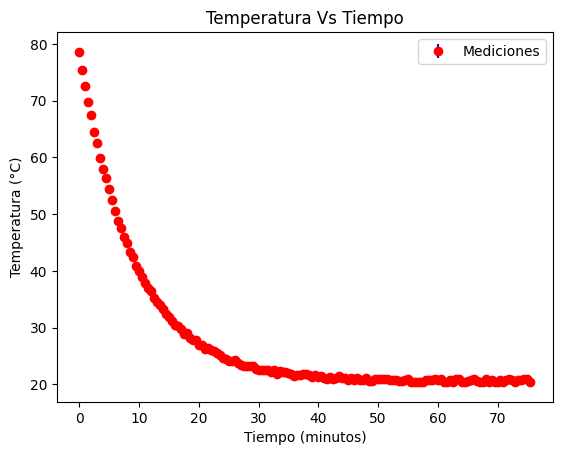

In [6]:
x=df["Tiempo"]
y=df["Temperatura"]
plt.errorbar(x,y,color="red",fmt="o",ecolor="blue",yerr=0.5,label="Mediciones")
plt.xlabel("Tiempo (minutos)")
plt.ylabel("Temperatura (°C)")
plt.title("Temperatura Vs Tiempo")
plt.legend()
plt.show()

Ya que el modelo es claramente exponencial se usará la siguiente ecuación:

f(x)=w_0 e^{w1x}+w2.

w_0, w_1, w_2 y son los parámetros a estimar.

¿Qué sabemos sobre los intervalos donde deben estar los parámetros?



*   w0 debe ser positivo ya que en la gráfica se ve que en el eje de la temperatura viene de inf, si fuera negativo vendría de -inf
*   Debido a la forma de la gráfica w1 debe ser negativa -ya que la exponencial tiende a 0-
*   w2 debe ser positivo y cercano a 20, ya que los datos parecen ya no cambiar de forma apreciable en torno a esta medición.





In [7]:
#Implementación de MCMC

import numpy as np

# Definir el modelo
def model_polinomial(parameters, x):
    sum=0
    for i in (len(parameters)):
      sum+=parameters[i]*(x**i)
    return sum

def model_exponencial(parameters, x):
    w0,w1,w2 = parameters
    return parameters[0]*np.exp(parameters[1]*x)+parameters[2]

# Definir la función de likelihood
def log_likelihood(parameters, x, y, yerr):
    y_pred = model_exponencial(parameters, x)
    return -0.5 * np.sum((y - y_pred)**2 / yerr**2)

# Definir la función de prior
def log_prior(parameters):
    w0, w1, w2 = parameters
    if 55 < w0 < 60 and -0.5 < w1 < 0 and 20 < w2 < 25  : #DELIMITAR PARAMETROS
        return 0.0
    return -np.inf

# Definir la función de log probabilidad (likelihood + prior)
def log_probability(parameters, x, y, yerr):
    lp = log_prior(parameters)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(parameters, x, y, yerr)

In [13]:
# Configuración MCMC
nchains = 8  #Numero de cadenas
dims = 3       # Se van a estimar 4 parametros: w0,w1,w2 y w3
samples = 1000  # Número de pasos por cadena

#ya que 55 < w0 < 60 and -0.5 < w1 < 0 and 20 < w2 < 25
#intentaremos con el numero de enmedio, es decir:
#w0=57.5,w1=-0.25,w2=22.5
coefs_iniciales=np.array([57.5,-0.25,22.5])
yerr=0.5 #error de la medicion

# Parámetros iniciales para las cadenas
initial_parameters = coefs_iniciales + 1e-4 * np.random.randn(nchains, dims)

# Crear el objeto emcee.EnsembleSampler
sampler = emcee.EnsembleSampler(nchains, dims, log_probability, args=(x, y, yerr))

# Ejecutar el MCMC
sampler.run_mcmc(initial_parameters, samples,progress=True)

100%|██████████| 1000/1000 [00:08<00:00, 111.20it/s]


State([[57.98717978 -0.11017189 20.68251621]
 [58.15661952 -0.11136842 20.73796833]
 [57.81694208 -0.10949733 20.63191614]
 [57.54352354 -0.10919638 20.62162627]
 [57.67472456 -0.10868459 20.47448286]
 [57.69568285 -0.10926018 20.66349161]
 [58.251041   -0.11038062 20.70119395]
 [57.7482189  -0.10928201 20.55907149]], log_prob=[-11.68824783 -14.90499407 -10.87455707 -12.48959767 -15.49667774
 -11.64480935 -13.63501785 -12.15976257], blobs=None, random_state=('MT19937', array([3689947672, 2951974470,  949181841, 4123881868, 2613772947,
       4010771594,  414526560, 2491361270, 3530882082,  127312236,
       3110004293, 3226505757,  615053506, 4182997282, 3081917379,
       2682228559, 2537929576, 1913369391,  831325084, 3092755057,
       1676856286,  210103512,  362155656, 2786066844, 2319230340,
       1674743776, 1397777914, 3456320592, 3060012099, 1125739093,
        905095697, 2811026918,  808513008, 3424992536, 1156338069,
       1499262691, 3979966777, 3126192792, 4280764311, 16

In [14]:
chains=sampler.chain #arreglo de matrices, cada matriz es una cadena
chain=np.vstack(chains) #junto las 8 matrices de cadenas en una sola matriz
w0=np.zeros(samples*nchains)
w1=np.zeros(samples*nchains)
w2=np.zeros(samples*nchains)

for i in range (samples*nchains):
  #guardo todos los parametros aceptados
  w0[i]=chain[i][0]
  w1[i]=chain[i][1]
  w2[i]=chain[i][2]
w=np.array([np.mean(w0),np.mean(w1),np.mean(w2)])
print("w0=",w[0],"w1=",w[1],"w2=",w[2])

w0= 57.94264777287925 w1= -0.11806165169995564 w2= 20.8460352912647


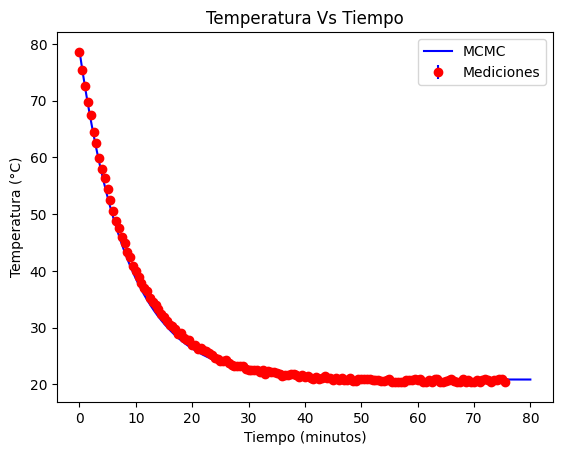

In [15]:
#comparación entre el modelo mcmc y los datos reales

A=np.linspace(0,80,800)
B=model_exponencial(w,A)
plt.plot(A,B,color="blue",label="MCMC")
plt.errorbar(x,y,color="red",fmt="o",ecolor="blue",yerr=0.5,label="Mediciones")
plt.xlabel("Tiempo (minutos)")
plt.ylabel("Temperatura (°C)")
plt.title("Temperatura Vs Tiempo")
plt.legend()
plt.show()

In [16]:
#diagnóstico gelman-rubin

def si2(cadena,n_parametro):
  aux=cadena[:,n_parametro]
  mean=np.mean(aux) #media de la cadena
  sum=0
  for i in range (len(aux)):
    sum+=(aux[i]-mean)**2
  return sum/(len(aux)-1)

def s2(cadenas,ncadenas,n_parametro):
  sum=0
  for i in range (ncadenas):
    sum+=si2(cadenas[i],n_parametro) #calculo si de cada cadena
  return sum/ncadenas

def Bn(cadenas,ncadenas,total_mean,n_parametro):
  sum=0
  for i in range (ncadenas):
    cadena=cadenas[i] #fijo una cadena
    aux=cadena[:,n_parametro]
    mean=np.mean(aux) #calculo la media de esa cadena
    sum+=(mean-total_mean)**2 #media de la cadena - media total del parametro
  return sum/(ncadenas-1)

def sigma2(cadenas,ncadenas,total_mean,n_parametro,npasos):
  aux=((npasos-1)/npasos)*s2(cadenas,ncadenas,n_parametro)+Bn(cadenas,ncadenas,total_mean,n_parametro)
  return aux

def R(cadenas,ncadenas,total_mean,n_parametro,npasos):
  aux=np.sqrt(sigma2(cadenas,ncadenas,total_mean,n_parametro,npasos)/s2(cadenas,ncadenas,n_parametro))
  return aux

print("R de w0: ",R(chains,nchains,w[0],0,samples))
print("R de w1: ",R(chains,nchains,w[1],1,samples))
print("R de w2: ",R(chains,nchains,w[2],2,samples))
#Ya que las tres R son cercanas, entonces es probable que las cadenas ya hayan convergid

R de w0:  1.0093140582521427
R de w1:  0.9997233187857875
R de w2:  1.0011850689839392


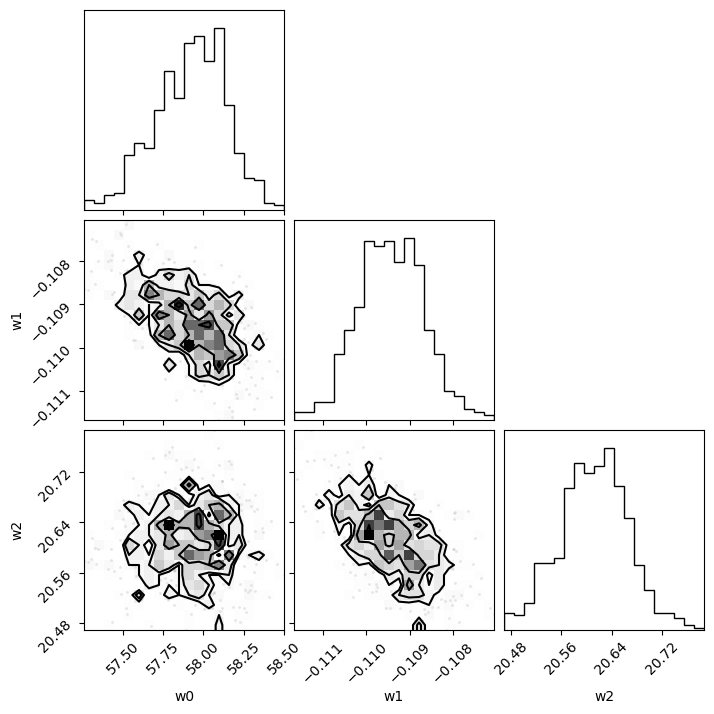

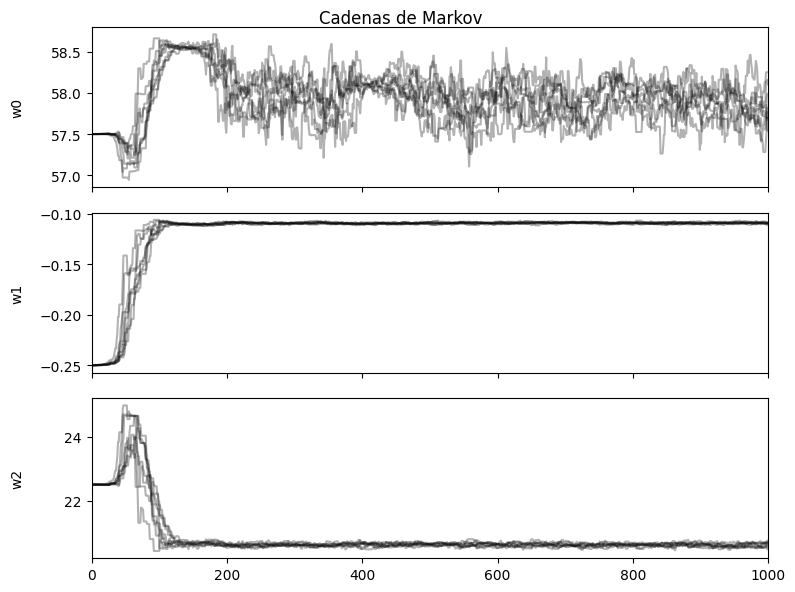

In [18]:
#Triangle Plot

import corner

samples = sampler.get_chain(discard=250, thin=10, flat=True)
#cadena descartando 100 muestras, manteniendo una de cada 10 muestras y aplanando
param_names = ["w0","w1","w2"]

fig = corner.corner(samples, labels=param_names)
#crear triangle plot con corner, son las graficas que parecen un camino

samples = sampler.get_chain()
#nuevamente cargo la cadena, PERO sin descartar ninguna muestra

# Configurar subtramas para cada parámetro
fig, axes = plt.subplots(len(param_names), figsize=(8, 6), sharex=True)
fig.suptitle("Cadenas de Markov")

# grafuci cada cadena, aqui es donde no descarto nada
for i in range(len(param_names)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(param_names[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

Notemos que en las graficas de las cadenas de markov, los parametros w0 y w2 se empiezan a estabilizar alrededor de las 200 muestras. W1 parecería estabilizarse desde alrededor de las 100 muestras